In [1]:
%matplotlib inline

In [2]:
# Model architecture
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, Flatten, SpatialDropout1D
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import Callback

# General packages
import numpy as np
import os
import h5py
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation and validation packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Jupyter interactive plotting
from IPython.display import clear_output

Using TensorFlow backend.


# Callback functions

Callback functions, as the name suggests, are type of functions that are called by particular part of your code the moment it executes and process the data. In the following case I created the simple class than can be used to plot the value of loss function and accuracy during the training/validation of the model.

It will be called by `fit` method of `Sequential` object in order to train the model.

In [3]:
# real time plotting
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_accuracies.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.accuracies, label="accuracy")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.val_accuracies, label="val_accuracy")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show();
        
plot_losses = PlotLosses()

# Data preparation

Here I prepare the data for the model as was described in previous notebooks.

In [5]:
hdf5_filename = "ts.h5"
h5=h5py.File(hdf5_filename, 'r')
inputs = np.array(h5["inputs"])
targets = np.array(h5["targets"])
h5.close()

In [6]:
n_classes = targets.max() + 1

### Let's scale the data

You can either scale each signal separately or with respect to the strongest value in the dataset.

This part is crucial and might strongly impact the behaviour of your model.

In [7]:
# Separate scaling to the range 0-1
inputs = preprocessing.minmax_scale(inputs.T).T

In [8]:
# Scale w.r.t. the strongest value to the range 0-1
#scale_factor_max = inputs.max()
#scale_factor_min= inputs.min()
#for i in range(inputs.shape[0]):
#    inputs[i] = (inputs[i] - scale_factor_min) / (scale_factor_max - scale_factor_min)

### Reshape the data - Tensorflow's CNN require the input to have 3 dimensions:
- n_samples
 
- n_features

- n_channels (in our case - just 1)

In [12]:
inputs = inputs.reshape((inputs.shape[0], inputs.shape[1], 1))

In [10]:
# Let's convert labels into one hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
targets = targets.reshape(targets.shape[0], 1)
targets = onehot_encoder.fit_transform(targets)

/home/fmorawski/DLEnv/quad3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [13]:
# Split the data for training and validation
x_train, x_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.3)

# Data architecture

**Important note!** Keras can work either with Tensorflow background or Theano. They differ in one crucial aspect - shape of the data.

Tensorflow requires the data to be stored in the following way (for 1D CNN):

- n_samples, n_features, n_channels

Whereas Theano requires:

- n_samples, n_channels, n_features

Channel in case of 2D CNN denotes to amount of colors on the image but in case of 1D it can be used to express one feature based on two datasets.

Make sure that the shape of the data is correct with respect to the Tensorflow.

In [15]:
model = Sequential()
model.add(Conv1D(nb_filter=40, filter_length=3, activation="relu", input_shape=(inputs.shape[1],1)))
model.add(MaxPool1D(2))
#model.add(SpatialDropout1D(0.2))

model.add(Conv1D(nb_filter=20, filter_length=3, activation="relu"))
model.add(MaxPool1D(2))
#model.add(Dropout(0.2))

# Flatten your convolutional part to fit the dense part of the model
model.add(Flatten())

model.add(Dense(200, activation="relu"))
model.add(Dense(n_classes, activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.


/home/fmorawski/DLEnv/quad3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(8192, 1), filters=40, kernel_size=3)`
  
/home/fmorawski/DLEnv/quad3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=20, kernel_size=3)`
  


In [16]:
opt = optimizers.Adam(lr=0.001)

In [17]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["acc"])

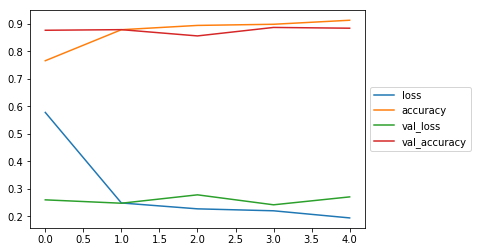

In [18]:
model.fit(x_train, y_train,
                epochs=5,
                batch_size=64,
                validation_data=(x_val, y_val),
                callbacks=[plot_losses])

In [19]:
y_predicted = model.predict(x_val)

In [20]:
cms = confusion_matrix(y_val.argmax(1), y_predicted.argmax(1))

In [21]:
test_score = np.trace(cms) / np.sum(cms)

Text(0, 0.5, 'Predicted label')

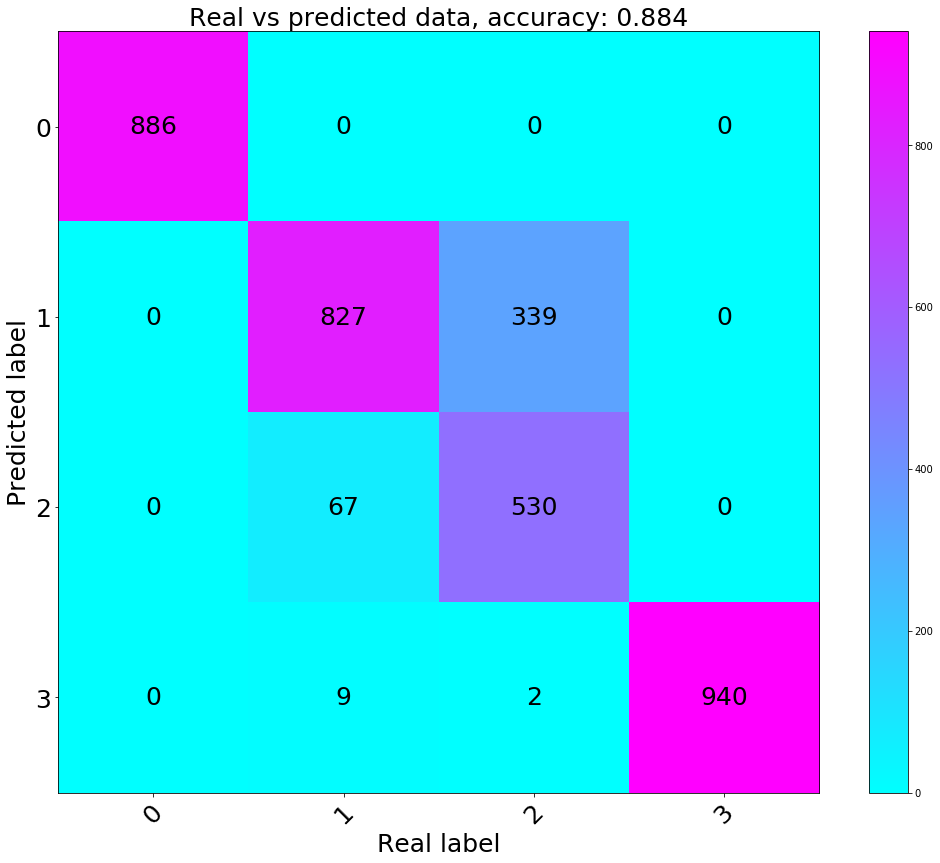

In [27]:
fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(cms), interpolation="nearest", cmap="cool")
rows = cms.shape[0]
cols = cms.shape[1]

for x in range(0, rows):
    for y in range(0, cols):
        value = int(cms[x, y])
        ax.text(x, y, value, color="black", ha="center", va="center", fontsize=25)
plt.title("Real vs predicted data, accuracy: " + str(test_score)[:5], fontsize=25)
plt.colorbar(im)

classes_values = []
classes_labels = []
for n in range(n_classes):
    classes_values.append(n)
    classes_labels.append(str(n))

#plt.xticks([0, 1, 2, 3, 4], ["0", "1", "2", "3", "4"], rotation=45, fontsize=25)
#plt.yticks([0, 1, 2, 3, 4], ["0", "1", "2", "3", "4"], fontsize=25)
plt.xticks(classes_values, classes_labels, rotation=45, fontsize=25)
plt.yticks(classes_values, classes_labels, fontsize=25)
plt.xlabel("Real label", fontsize=25)
plt.ylabel("Predicted label", fontsize=25)

# Suggestions

### 1. Increase the amplitude of the noise

### 2. Create unbalanced dataset - check what happens when you have only few signals for the given class

### 3. Move the signal along the time vector - more realistic dataset might contain signals split at some point. You can generate such a dataset and see how CNN will work with only partial information.

### 4. Create images instead of time-series.